# Filtering and Coarse Graining 

### Filtering:
- Gaussian filter
- Box filter
- Spectral Filter

### Coarse graining 
- Spectral space

In [38]:
import numpy as np
from scipy.fftpack import fft2, ifft2
import matplotlib.pyplot as plt
from scipy.io import loadmat

from py2d.initialize import initialize_wavenumbers_2DFHIT
from py2d.convert import Omega2Psi_2DFHIT
from py2d.spectra import spectrum_angled_average_2DFHIT
from py2d.filter import filter2D_2DFHIT

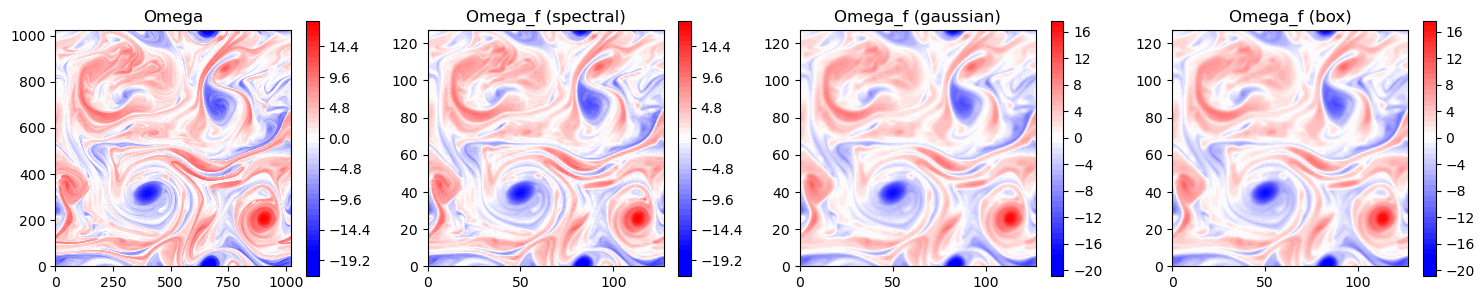

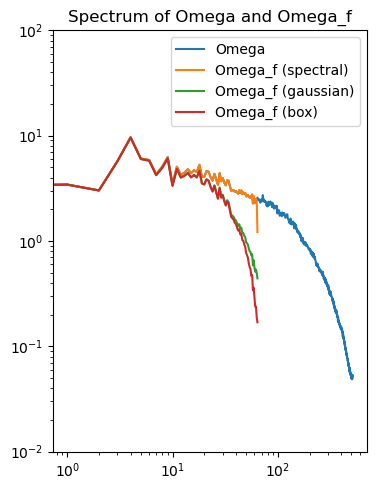

In [39]:
nx = 1024
filename = '../data/ICs/NX' + str(nx) + '/1.mat'
Lx = 2 * np.pi

NCoarse = 128
Delta = 2*Lx/NCoarse

filter_types = ['spectral', 'gaussian', 'box']  # Define filter types

Kx, Ky, Kabs, Ksq, invKsq = initialize_wavenumbers_2DFHIT(nx, nx, Lx, Lx, INDEXING='ij')

# load the data from the file
data = loadmat(filename)
# get the Omega data from the file
Omega = data['Omega']

# calculate Psi from Omega using the Omega2Psi_2DFHIT function
Psi = Omega2Psi_2DFHIT(Omega, invKsq=invKsq)

# Create a common colorbar range
vmax = Omega.max()
vmin = -vmax

# Initialize figure for contour
fig_contour, axs_contour = plt.subplots(1, len(filter_types) + 1, figsize=(15, 3))  # plus 1 for original Omega

# Initialize figure for spectrum
fig_spectrum, axs_spectrum = plt.subplots(figsize=(6, 5))

# Contour of original Omega
c = axs_contour[0].contourf(Omega, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
axs_contour[0].set_title('Omega')
axs_contour[0].set_aspect('equal')
fig_contour.colorbar(c, ax=axs_contour[0], orientation='vertical')

# Calculate the absolute value of the Fourier transform of Omega
Omega_abs_hat = np.sqrt(np.fft.fft2(Omega)*np.conj(np.fft.fft2(Omega)))

# Calculate the spectrum using the spectrum_angled_average_2DFHIT function
spectrum_angled_Omega, wavenumbers_angled_Omega = spectrum_angled_average_2DFHIT(Omega_abs_hat, spectral=True)

# Spectrum of Omega
axs_spectrum.loglog(wavenumbers_angled_Omega, spectrum_angled_Omega, label='Omega')
axs_spectrum.set_ylim([1e-2, 1e2])

# Contour and spectrum for each filter type
for i, filter_type in enumerate(filter_types):
    # Calculate filtered Omega
    Omega_f = filter2D_2DFHIT(Omega, filterType=filter_type, coarseGrainType='spectral', Delta=Delta, Ngrid=NCoarse)

    # Contour of filtered Omega
    c = axs_contour[i + 1].contourf(Omega_f, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
    axs_contour[i + 1].set_title(f'Omega_f ({filter_type})')
    axs_contour[i + 1].set_aspect('equal')
    fig_contour.colorbar(c, ax=axs_contour[i + 1], orientation='vertical')

    # Calculate the absolute value of the Fourier transform of Omega_f
    Omega_f_abs_hat = np.sqrt(np.fft.fft2(Omega_f)*np.conj(np.fft.fft2(Omega_f)))

    # Calculate the spectrum using the spectrum_angled_average_2DFHIT function
    spectrum_angled_Omega_f, wavenumbers_angled_Omega_f = spectrum_angled_average_2DFHIT(Omega_f_abs_hat, spectral=True)

    # Spectrum of filtered Omega
    axs_spectrum.loglog(wavenumbers_angled_Omega_f, spectrum_angled_Omega_f, label=f'Omega_f ({filter_type})')
    axs_spectrum.set_aspect('equal')

# Set title and legend for spectrum plot
axs_spectrum.set_title('Spectrum of Omega and Omega_f')
axs_spectrum.legend()

# Layout adjustment
fig_contour.tight_layout()
fig_spectrum.tight_layout()

# Display plots
plt.show()
